In [230]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges
import plotly.express as px
from sklearn import preprocessing
import pylab as pl

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Create SwanGraph

In [2]:
annot = '../../refs/gencode_v29_sirv4_ercc.gtf'
ab = '../talon/human_talon_abundance_filtered.tsv'
gtf = '../talon/human_known_nic_nnc_talon.gtf'

In [3]:
sg = swan.SwanGraph()
sg.add_annotation(annot)
sg.add_transcriptome(gtf)
sg.add_abundance(ab)

In [5]:
sg.save_graph('swan')

Saving graph as swan.p


## Get metadata

In [32]:
sg = swan.read('swan.p')
meta = sg.adata.obs.copy(deep=True)
meta.reset_index(inplace=True, drop=True)
meta['sample'] = meta.dataset.str.rsplit('_', n=2, expand=True)[0]

tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
tissue_df.rename({'biosample': 'sample'}, axis=1, inplace=True)

meta = meta.merge(tissue_df, how='left', on='sample')
meta.head()
meta['classification'] = 'tissue'
meta.loc[meta.tissue.isnull(), 'classification'] = 'cell_line'

meta.loc[meta.tissue.isnull(), 'tissue'] = meta.loc[meta.tissue.isnull(), 'sample']
meta.drop('sample', axis=1, inplace=True)
meta.rename({'tissue': 'sample'}, axis=1, inplace=True)

print('Found {} total samples'.format(len(meta['sample'].unique().tolist())))

Read in graph from swan.p
Found 31 total samples


In [34]:
meta.to_csv('swan_metadata.tsv', sep='\t', index=False)

## Add metadata

In [35]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [36]:
meta = 'swan_metadata.tsv'
sg.add_metadata('swan_metadata.tsv')

# colors
c_dict, order = get_biosample_colors()
sg.set_metadata_colors('sample', c_dict)

sg.save_graph('swan')

Saving graph as swan.p


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


## Pi / major isoform stuff

Read in graph from swan.p


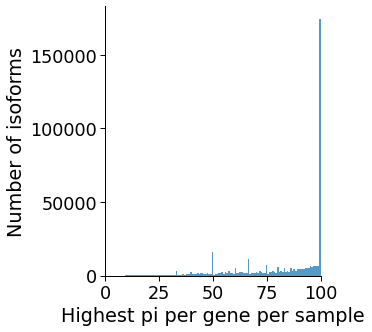

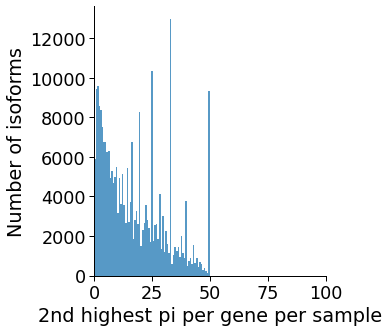

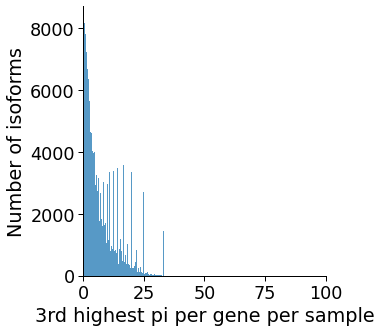

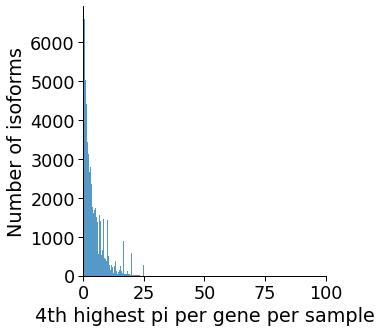

In [2]:
sg = swan.read('swan.p')
plot_major_iso_pis(sg, 'sample', opref='figures/human')

### How many isoforms does it take to get 90% expression / gene / sample?

In [340]:
sg = swan.read('swan.p')
sg.adata.obs['biosample'] = sg.adata.obs['dataset'].str.rsplit('_', n=2, expand=True)[0]

Read in graph from swan.p


In [341]:
len(sg.adata.obs.biosample.unique())

44

In [342]:
sg.adata.obs.groupby('classification').nunique()

,dataset,total_counts,biosample,sample
classification,,,,
cell_line,48,48,21,21
tissue,42,42,23,10


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [12]:
sg = swan.read('swan.p')
t_df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')

Read in graph from swan.p


In [13]:
t_df = t_df[['annot_gene_name', 'annot_transcript_id', 'annot_gene_id']]
t_df.rename({'annot_gene_name': 'gname',
             'annot_gene_id': 'gid',
             'annot_transcript_id': 'tid'}, 
             axis=1, 
             inplace=True)

df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col='sample')
df = df.sparse.to_dense()
df = df.transpose()
df = df.merge(t_df[['tid', 'gname', 'gid']], how='inner', on='tid')

df.set_index(['tid', 'gname', 'gid'], inplace=True)
df = df.melt(ignore_index=False, value_name='pi', var_name='biosample')
df = df.dropna(subset=['pi'])
df.reset_index(inplace=True)

# determine the rank of each pi value for each sample / gene combo
df = df.sort_values(by='pi', ascending=False)
df['pi_rank'] = df.sort_values(by='pi', ascending=False).groupby(['gname', 'gid', 'biosample']).cumcount()+1

# add a column that we can check for convergence with 
df['gname_gid_biosamp'] = df.gname+'_'+df.gid+'_'+df.biosample

iso_df = pd.DataFrame()
max_pi_rank = df.pi_rank.max()
for max_pi in range(1, max_pi_rank+1):
    pi_ranks = [i for i in range(1, max_pi+1)]
    # for the first iteration, we don't have to limit which genes we look at
    if max_pi == 1:
        temp = df.loc[df.pi_rank.isin(pi_ranks)].groupby(['gname_gid_biosamp']).sum().reset_index()
    else:
        ids = iso_df.gname_gid_biosamp.tolist()
        temp = df.loc[(~df.gname_gid_biosamp.isin(ids))&(df.pi_rank.isin(pi_ranks))].groupby(['gname_gid_biosamp']).sum().reset_index()
    
    # converged if no more entries to analyze
    if len(temp.index) == 0:
        break
    
    # get isoforms that have >90% isoform exp accounted for
    temp = temp.loc[temp.pi >= 90]
    temp.drop(['pi_rank'], axis=1, inplace=True)
    temp['n_isos'] = max_pi
    
    iso_df = pd.concat([iso_df, temp])

# get list of isoforms required for each sample / gene combination as well
df = df.merge(iso_df, how='left', on='gname_gid_biosamp')
df['in_90_set'] = df.pi_rank <= df.n_isos
df = df.loc[df.in_90_set]
df[['gname', 'gid', 'biosample']] = df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
df.rename({'pi_x': 'pi'}, axis=1, inplace=True)
df.drop(['gname_gid_biosamp', 
        'pi_y', 'n_isos', 'in_90_set'], axis=1, inplace=True)

# get the sample / gene vs. n isoforms required for 90%    
iso_df[['gname', 'gid', 'biosample']] = iso_df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
iso_df.drop('gname_gid_biosamp', axis=1, inplace=True)
iso_df = iso_df.sort_values('n_isos', ascending=False)

In [14]:
df.to_csv('isos_sample_gene_90.tsv', sep='\t', index=False)

In [15]:
df.head()

,tid,gname,gid,biosample,pi,pi_rank
0,ENST00000253462.7,GINS2,ENSG00000131153.8,pgp1_excite_neuron,100.0,1
1,ENST00000297578.8,SLC25A32,ENSG00000164933.11,pgp1_endo,100.0,1
2,ENST00000379144.6,PCYT1B,ENSG00000102230.13,h9_panc_beta,100.0,1
3,ENST00000251810.7,RRM2B,ENSG00000048392.11,pgp1_endo,100.0,1
4,ENST00000520820.1,UBR5-AS1,ENSG00000246263.2,pgp1_endo,100.0,1


In [353]:
iso_df.to_csv('n_isos_sample_gene_90.tsv', sep='\t', index=False)

In [118]:
opref = 'figures/human'

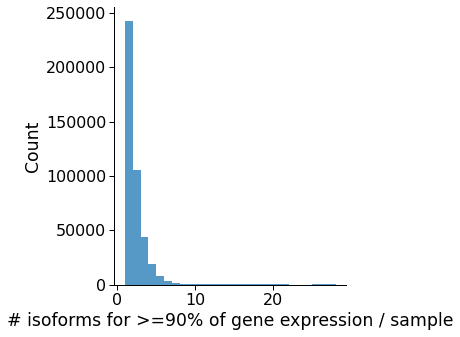

In [120]:
sns.set_context('paper', font_scale=1.8)
ax = sns.displot(data=iso_df, x='n_isos',
                 kind='hist',
                 binwidth=1,
                 linewidth=0)

xlabel = '# isoforms for >=90% of gene expression / sample'
ylabel = 'Count'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = '{}_isos_pi_90.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')   

### Gene-level exon analysis

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


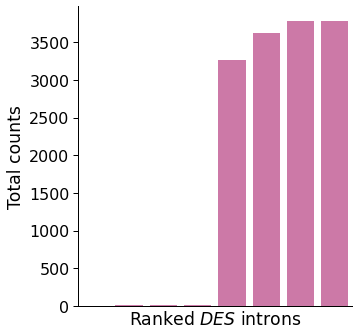

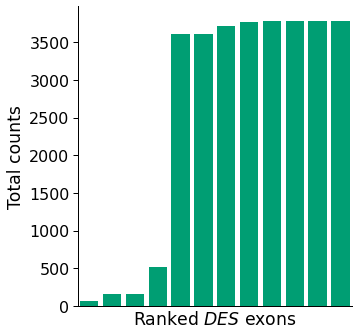

In [5]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'DES', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 90 total libraries


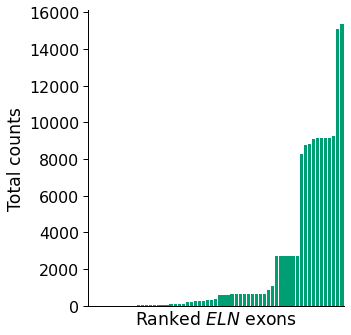

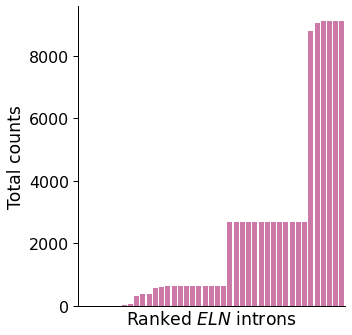

In [4]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'ELN', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Found 139 isoforms for ELN


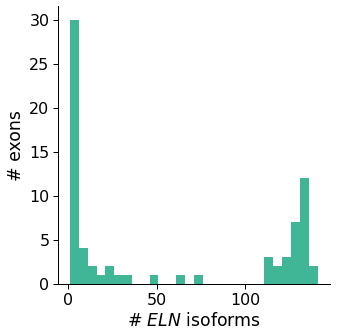

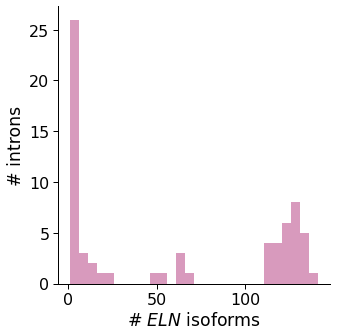

In [2]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
plot_exon_hist(sg, df, 'ELN',
               min_tpm=1,
               gene_subset='polya',
               sample='all', 
               groupby='sample', 
               nov=['Known', 'NIC', 'NNC'], 
               opref='figures/human')

In [3]:
sg.plot_graph('ELN', indicate_novel=True, prefix='figures/eln')

Saving summary graph for ENSG00000049540.16 as figures/eln_novel_ENSG00000049540.16_summary.png


In [4]:
sg.plot_graph('DES', indicate_novel=True, prefix='figures/des')

Saving summary graph for ENSG00000175084.11 as figures/des_novel_ENSG00000175084.11_summary.png


In [5]:
sg.plot_transcript_path('ENST00000373960.3', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENST00000373960.3 as figures/des_novel_ENST00000373960.3_path.png


In [6]:
sg.plot_transcript_path('ENCODEHT002835059', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENCODEHT002835059 as figures/des_novel_ENCODEHT002835059_path.png


## Reports

In [16]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [17]:
def make_biosamp_reports(sg, gene):
    def make_reports(sg, gene, c):
        opref = 'figures/{}_{}'.format(gene.lower(), c)
        sg.gen_report(gene,
                  prefix=opref,
                  layer='pi',
                  cmap='magma',
                  novelty=True,
                  groupby='biosample',
                  transcript_name=True,
                  metadata_cols=['biosample'],
                  datasets={'classification': c},
                  browser=True)

        sg.gen_report(gene,
                      prefix=opref,
                      layer='tpm',
                      cmap='viridis',
                      novelty=True,
                      groupby='biosample',
                      transcript_name=True,
                      metadata_cols=['biosample'],
                      indicate_novel=True,
                      datasets={'classification': c})
        
    c = 'tissue'
    make_reports(sg, gene, c)
    c = 'cell_line'
    make_reports(sg, gene, c)    

In [129]:
make_biosamp_reports(sg, 'COL1A1')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_tissue_browser_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_tissue_browser_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000463440.1 as figures/col1a1_tissue_browser_ENST00000463440.1_path.png
Generating report for ENSG00000108821.13


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_tissue_novel_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_tissue_novel_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000463440.1 as figures/col1a1_tissue_novel_ENST00000463440.1_path.png
Generating report for ENSG00000108821.13


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_cell_line_browser_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_cell_line_browser_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000476387.1 as figures/col1a1_cell_line_browser_ENST00000476387.1_path.png
Generating report for ENSG00000108821.13


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_cell_line_novel_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_cell_line_novel_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000476387.1 as figures/col1a1_cell_line_novel_ENST00000476387.1_path.png
Generating report for ENSG00000108821.13


In [127]:
make_biosamp_reports(sg, 'CAST')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENCODEHT000470977 as figures/cast_tissue_browser_ENCODEHT000470977_path.png
Saving transcript path graph for ENST00000309190.9 as figures/cast_tissue_browser_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000470926 as figures/cast_tissue_browser_ENCODEHT000470926_path.png
Saving transcript path graph for ENCODEHT000470707 as figures/cast_tissue_browser_ENCODEHT000470707_path.png
Saving transcript path graph for ENCODEHT000471452 as figures/cast_tissue_browser_ENCODEHT000471452_path.png
Saving transcript path graph for ENCODEHT001378016 as figures/cast_tissue_browser_ENCODEHT001378016_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_tissue_browser_ENCODEHT000471422_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_tissue_browser_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_tissue_browser_E

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENCODEHT000470977 as figures/cast_tissue_novel_ENCODEHT000470977_path.png
Saving transcript path graph for ENST00000309190.9 as figures/cast_tissue_novel_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000470926 as figures/cast_tissue_novel_ENCODEHT000470926_path.png
Saving transcript path graph for ENCODEHT000470707 as figures/cast_tissue_novel_ENCODEHT000470707_path.png
Saving transcript path graph for ENCODEHT000471452 as figures/cast_tissue_novel_ENCODEHT000471452_path.png
Saving transcript path graph for ENCODEHT001378016 as figures/cast_tissue_novel_ENCODEHT001378016_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_tissue_novel_ENCODEHT000471422_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_tissue_novel_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_tissue_novel_ENCODEHT000471440_p

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENST00000309190.9 as figures/cast_cell_line_browser_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_cell_line_browser_ENCODEHT000471422_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_cell_line_browser_ENCODEHT000471440_path.png
Saving transcript path graph for ENST00000508608.5 as figures/cast_cell_line_browser_ENST00000508608.5_path.png
Saving transcript path graph for ENST00000395812.6 as figures/cast_cell_line_browser_ENST00000395812.6_path.png
Saving transcript path graph for ENCODEHT000470977 as figures/cast_cell_line_browser_ENCODEHT000470977_path.png
Saving transcript path graph for ENCODEHT000471188 as figures/cast_cell_line_browser_ENCODEHT000471188_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_cell_line_browser_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000470699 as figur

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENST00000309190.9 as figures/cast_cell_line_novel_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_cell_line_novel_ENCODEHT000471422_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_cell_line_novel_ENCODEHT000471440_path.png
Saving transcript path graph for ENST00000508608.5 as figures/cast_cell_line_novel_ENST00000508608.5_path.png
Saving transcript path graph for ENST00000395812.6 as figures/cast_cell_line_novel_ENST00000395812.6_path.png
Saving transcript path graph for ENCODEHT000470977 as figures/cast_cell_line_novel_ENCODEHT000470977_path.png
Saving transcript path graph for ENCODEHT000471188 as figures/cast_cell_line_novel_ENCODEHT000471188_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_cell_line_novel_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000470699 as figures/cast_cell_lin

In [128]:
make_biosamp_reports(sg, 'GGT1')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_tissue_browser_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_tissue_browser_ENCODEHT000414250_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_tissue_browser_ENST00000403838.5_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_tissue_browser_ENST00000400382.5_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_tissue_browser_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414190 as figures/ggt1_tissue_browser_ENCODEHT000414190_path.png
Saving transcript path graph for ENCODEHT000414211 as figures/ggt1_tissue_browser_ENCODEHT000414211_path.png
Saving transcript path graph for ENCODEHT000414244 as figures/ggt1_tissue_browser_ENCODEHT000414244_path.png
Saving transcript path graph for ENCODEHT000414236 as figures/ggt1_tissue_browser_E

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_tissue_novel_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_tissue_novel_ENCODEHT000414250_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_tissue_novel_ENST00000403838.5_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_tissue_novel_ENST00000400382.5_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_tissue_novel_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414190 as figures/ggt1_tissue_novel_ENCODEHT000414190_path.png
Saving transcript path graph for ENCODEHT000414211 as figures/ggt1_tissue_novel_ENCODEHT000414211_path.png
Saving transcript path graph for ENCODEHT000414244 as figures/ggt1_tissue_novel_ENCODEHT000414244_path.png
Saving transcript path graph for ENCODEHT000414236 as figures/ggt1_tissue_novel_ENCODEHT000414236_p

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_cell_line_browser_ENCODEHT000414250_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_cell_line_browser_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_cell_line_browser_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414265 as figures/ggt1_cell_line_browser_ENCODEHT000414265_path.png
Saving transcript path graph for ENCODEHT000414207 as figures/ggt1_cell_line_browser_ENCODEHT000414207_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_cell_line_browser_ENST00000400382.5_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_cell_line_browser_ENST00000403838.5_path.png
Saving transcript path graph for ENCODEHT000414181 as figures/ggt1_cell_line_browser_ENCODEHT000414181_path.png
Saving transcript path graph for ENCODEHT000414194 as figur

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_cell_line_novel_ENCODEHT000414250_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_cell_line_novel_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_cell_line_novel_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414265 as figures/ggt1_cell_line_novel_ENCODEHT000414265_path.png
Saving transcript path graph for ENCODEHT000414207 as figures/ggt1_cell_line_novel_ENCODEHT000414207_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_cell_line_novel_ENST00000400382.5_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_cell_line_novel_ENST00000403838.5_path.png
Saving transcript path graph for ENCODEHT000414181 as figures/ggt1_cell_line_novel_ENCODEHT000414181_path.png
Saving transcript path graph for ENCODEHT000414194 as figures/ggt1_cell_lin

In [64]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_pi',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'cell_line'},
              browser=True)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_pi_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_pi_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_pi_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_pi_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_pi_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_pi_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_pi_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_pi_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT

In [7]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'cell_line'},
              browser=True)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln

In [18]:
make_biosamp_reports(sg, 'MYOG')

               ENST00000469289.1  ENST00000417324.1  ENST00000461467.1  \
biosample                                                                
adrenal gland           0.000000                0.0                0.0   
adipose                 0.000000                0.0                0.0   
colon                   0.000000                0.0                0.0   
colon                   1.423607                0.0                0.0   
ovary                   0.000000                0.0                0.0   

               ENST00000442987.3  ENST00000494149.2  ENST00000410691.1  \
biosample                                                                
adrenal gland                0.0           3.233415                0.0   
adipose                      0.0           0.000000                0.0   
colon                        0.0           0.000000                0.0   
colon                        0.0           0.000000                0.0   
ovary                        0.0     

In [3]:
make_biosamp_reports(sg, 'MEF2C')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_tissue_browser_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_tissue_browser_ENCODEHT000458385_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_tissue_browser_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_tissue_browser_ENST00000508569.5_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_tissue_browser_ENST00000511086.1_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_tissue_browser_ENST00000637481.1_path.png
Saving transcript path graph for ENST00000629612.2 as figures/mef2c_tissue_browser_ENST00000629612.2_path.png
Saving transcript path graph for ENST00000627659.2 as figures/mef2c_tissue_browser_ENST00000627659.2_path.png
Saving transcript path graph for ENST00000424173.6 as figures/mef2c_tissue_

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_tissue_novel_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_tissue_novel_ENCODEHT000458385_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_tissue_novel_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_tissue_novel_ENST00000508569.5_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_tissue_novel_ENST00000511086.1_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_tissue_novel_ENST00000637481.1_path.png
Saving transcript path graph for ENST00000629612.2 as figures/mef2c_tissue_novel_ENST00000629612.2_path.png
Saving transcript path graph for ENST00000627659.2 as figures/mef2c_tissue_novel_ENST00000627659.2_path.png
Saving transcript path graph for ENST00000424173.6 as figures/mef2c_tissue_novel_ENST000004

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_cell_line_browser_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_cell_line_browser_ENCODEHT000458385_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_cell_line_browser_ENST00000508569.5_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_cell_line_browser_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_cell_line_browser_ENST00000511086.1_path.png
Saving transcript path graph for ENCODEHT000458359 as figures/mef2c_cell_line_browser_ENCODEHT000458359_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_cell_line_browser_ENST00000637481.1_path.png
Saving transcript path graph for ENCODEHT000458395 as figures/mef2c_cell_line_browser_ENCODEHT000458395_path.png
Saving transcript path graph for ENCODEHT000458420 

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_cell_line_novel_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_cell_line_novel_ENCODEHT000458385_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_cell_line_novel_ENST00000508569.5_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_cell_line_novel_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_cell_line_novel_ENST00000511086.1_path.png
Saving transcript path graph for ENCODEHT000458359 as figures/mef2c_cell_line_novel_ENCODEHT000458359_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_cell_line_novel_ENST00000637481.1_path.png
Saving transcript path graph for ENCODEHT000458395 as figures/mef2c_cell_line_novel_ENCODEHT000458395_path.png
Saving transcript path graph for ENCODEHT000458420 as figures/mef2c

In [4]:
make_biosamp_reports(sg, 'ELN')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000458204.5 as figures/eln_tissue_browser_ENST00000458204.5_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_browser_ENST0000

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_novel_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_novel_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_novel_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_novel_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_novel_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_novel_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_novel_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000458204.5 as figures/eln_tissue_novel_ENST00000458204.5_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_novel_ENST00000380575.8_path.png

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_novel_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_novel_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_novel_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_novel_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_novel_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_novel_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_novel_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_novel_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_novel

In [ ]:
make_biosamp_reports(sg, 'DES')

In [25]:
make_biosamp_reports('MYH7')


Plotting transcripts for ENSG00000092054.12
Saving transcript path graph for ENST00000355349.3 as figures/myh7_tissue_browser_ENST00000355349.3_path.png
Saving transcript path graph for ENCODEHT002509576 as figures/myh7_tissue_browser_ENCODEHT002509576_path.png
Saving transcript path graph for ENCODEHT002511948 as figures/myh7_tissue_browser_ENCODEHT002511948_path.png
Saving transcript path graph for ENCODEHT002511093 as figures/myh7_tissue_browser_ENCODEHT002511093_path.png
Saving transcript path graph for ENCODEHT002509562 as figures/myh7_tissue_browser_ENCODEHT002509562_path.png
Saving transcript path graph for ENCODEHT002509573 as figures/myh7_tissue_browser_ENCODEHT002509573_path.png
Saving transcript path graph for ENCODEHT002510879 as figures/myh7_tissue_browser_ENCODEHT002510879_path.png
Saving transcript path graph for ENCODEHT002509778 as figures/myh7_tissue_browser_ENCODEHT002509778_path.png
Saving transcript path graph for ENCODEHT002511483 as figures/myh7_tissue_browser_E

In [142]:
sg.set_metadata_colors('classification', {'cell_line': 'blue', 'tissue': 'pink'})
sg.gen_report('MYH7',
              prefix='figures/myh7_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['classification', 'biosample'],
              browser=True)


Plotting transcripts for ENSG00000092054.12
Saving transcript path graph for ENST00000355349.3 as figures/myh7_cell_line_browser_ENST00000355349.3_path.png
Saving transcript path graph for ENCODEHT002509576 as figures/myh7_cell_line_browser_ENCODEHT002509576_path.png
Saving transcript path graph for ENCODEHT002511948 as figures/myh7_cell_line_browser_ENCODEHT002511948_path.png
Saving transcript path graph for ENCODEHT002511093 as figures/myh7_cell_line_browser_ENCODEHT002511093_path.png
Saving transcript path graph for ENCODEHT002509573 as figures/myh7_cell_line_browser_ENCODEHT002509573_path.png
Saving transcript path graph for ENCODEHT002509778 as figures/myh7_cell_line_browser_ENCODEHT002509778_path.png
Saving transcript path graph for ENCODEHT002511483 as figures/myh7_cell_line_browser_ENCODEHT002511483_path.png
Saving transcript path graph for ENCODEHT002510879 as figures/myh7_cell_line_browser_ENCODEHT002510879_path.png
Saving transcript path graph for ENCODEHT002509562 as figur

In [141]:
sg.adata.obs.head()

,dataset,total_counts,biosample,classification,sample
index,,,,,
gm12878_1_1,gm12878_1_1,597843.0,gm12878,cell_line,gm12878
gm12878_1_2,gm12878_1_2,519604.0,gm12878,cell_line,gm12878
gm12878_1_3,gm12878_1_3,453017.0,gm12878,cell_line,gm12878
gm12878_1_4,gm12878_1_4,566864.0,gm12878,cell_line,gm12878
gm12878_3_1,gm12878_3_1,881857.0,gm12878,cell_line,gm12878


# where are the TSSs for Elastin?

In [15]:
df = sg.get_tss_abundance(kind='tpm')
df = df.loc[df.gname == 'ELN']

In [24]:
df

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936
6505,ENSG00000049540.16_6,ENSG00000049540.16,ELN,821942,ELN_6,chr7,74028124,0.0,0.0,0.0,...,0.000000,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6506,ENSG00000049540.16_7,ENSG00000049540.16,ELN,821943,ELN_7,chr7,74028126,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6507,ENSG00000049540.16_8,ENSG00000049540.16,ELN,821944,ELN_8,chr7,74028129,0.0,0.0,0.0,...,0.000000,0.000000,4.177217,1.987479,0.000000,0.0,0.000000,0.000000,2.460511,0.000000
6508,ENSG00000049540.16_9,ENSG00000049540.16,ELN,821945,ELN_9,chr7,74028141,0.0,0.0,0.0,...,0.000000,1.812553,0.596745,0.000000,1.755452,0.0,0.000000,0.000000,1.640341,2.272624
6509,ENSG00000049540.16_10,ENSG00000049540.16,ELN,821946,ELN_10,chr7,74028144,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [19]:
df.coord.max()-df.coord.min()

25062

In [21]:
df.coord.max()

74052851

In [22]:
df.coord.min()

74027789

In [26]:
tids = ['ENCODEHT001481409', 'ELN-209']

sg.t_df.loc[sg.t_df.tname.isin(tids), ['tname', 'loc_path']]

,tname,loc_path
tid,,
ENCODEHT001481409,ENCODEHT001481409,"[821951, 821955, 821956, 821957, 821959, 82196..."
ENST00000380576.9,ELN-209,"[821952, 821955, 821956, 821957, 821959, 82196..."


In [27]:
beep = sg.t_df.loc[sg.t_df.gname == 'ELN']

In [33]:
beep['tss'] = beep.apply(lambda x: x.loc_path[0], axis=1)
beep = beep.merge(df[['vertex_id', 'coord']], how='left', left_on='tss', right_on='vertex_id')

In [36]:
beep.loc[beep.tss == 822009]

,tname,gid,gname,path,tid,loc_path,annotation,novelty,tss,vertex_id,coord
147,ELN-224,ENSG00000049540.16,ELN,"[360442, 360443, 360344, 360345, 360346, 36034...",ENST00000466878.5,"[822009, 822010, 822012, 822015, 822016, 82201...",True,Known,822009,822009,74052294


In [43]:
df.head()

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936


In [48]:
# are the isoforms with the super far away tsss even expresed?
far_tss = [822009, 822011, 821967, 821992, 821989]
for tss in far_tss:
    print(df.loc[df.vertex_id == tss, sg.datasets].sum(axis=1))

6521    0.0
dtype: float32
6522    0.0
dtype: float32
6518    0.0
dtype: float32
6520    7.299387
dtype: float32
6519    0.0
dtype: float32


In [47]:
df.sort_values(by='coord')

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936
6505,ENSG00000049540.16_6,ENSG00000049540.16,ELN,821942,ELN_6,chr7,74028124,0.0,0.0,0.0,...,0.000000,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6506,ENSG00000049540.16_7,ENSG00000049540.16,ELN,821943,ELN_7,chr7,74028126,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6507,ENSG00000049540.16_8,ENSG00000049540.16,ELN,821944,ELN_8,chr7,74028129,0.0,0.0,0.0,...,0.000000,0.000000,4.177217,1.987479,0.000000,0.0,0.000000,0.000000,2.460511,0.000000
6508,ENSG00000049540.16_9,ENSG00000049540.16,ELN,821945,ELN_9,chr7,74028141,0.0,0.0,0.0,...,0.000000,1.812553,0.596745,0.000000,1.755452,0.0,0.000000,0.000000,1.640341,2.272624
6509,ENSG00000049540.16_10,ENSG00000049540.16,ELN,821946,ELN_10,chr7,74028144,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [49]:
74027789-74028188

-399

## Where are the TESs for MEF2C?

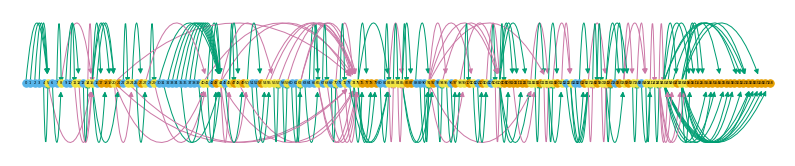

In [17]:
sg.plot_graph('MEF2C')

In [24]:
tids = sg.adata.var.index.tolist()
paths = sg.t_df.loc_path.values.tolist()
tess = [path[-1] for path in paths]
sg.t_df['tes'] = tess

sg.t_df.loc[(sg.t_df.index.isin(tids))&(sg.t_df.gname == 'MEF2C'), 'tes'].nunique()

17

In [27]:
counts.loc[counts.gname == 'MEF2C'].sort_values(by='tes', ascending=False)

,tss,intron_chain,tes,tss_ic_tes,gid,gname,sample,spl_ratio
5241,4,9,8,9,ENSG00000081189.15,MEF2C,vessels,1.500000
5240,6,14,8,14,ENSG00000081189.15,MEF2C,gm12878,2.000000
5241,3,7,6,7,ENSG00000081189.15,MEF2C,heart,1.555556
5241,2,8,6,8,ENSG00000081189.15,MEF2C,h9_neural_crest,2.000000
5241,2,6,6,6,ENSG00000081189.15,MEF2C,muscle,1.500000
5241,1,5,5,5,ENSG00000081189.15,MEF2C,pgp1_endo,1.666667
5241,1,6,5,6,ENSG00000081189.15,MEF2C,ovary,2.000000
5241,2,6,5,6,ENSG00000081189.15,MEF2C,lung,1.714286
5241,1,5,4,5,ENSG00000081189.15,MEF2C,adrenal gland,2.000000
5241,1,5,4,5,ENSG00000081189.15,MEF2C,adipose,2.000000


In [28]:
annot_counts.loc[annot_counts.gname == 'MEF2C']

,tss,intron_chain,tes,tss_ic_tes,gid,gname
37840,31,56,25,56,ENSG00000081189.15,MEF2C


In [29]:
obs_counts.loc[obs_counts.gname == 'MEF2C']

,tss,intron_chain,tes,tss_ic_tes,gid,gname
5240,10,23,14,23,ENSG00000081189.15,MEF2C


      tss  intron_chain  tes  tss_ic_tes                 gid  gname  \
5240   10            23   14          23  ENSG00000081189.15  MEF2C   

      spl_ratio  color  
5240   1.916667  color  


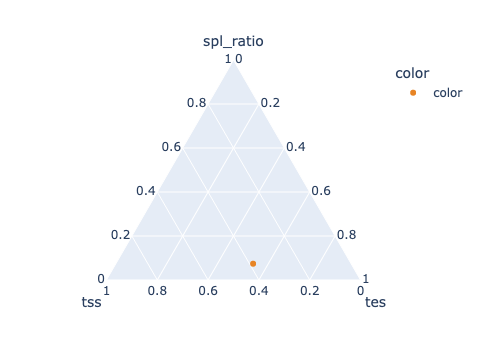

In [36]:
# ternary plot
# compute ratios anyway 
obs_counts['spl_ratio'] = obs_counts.intron_chain/((obs_counts.tss+obs_counts.tes)/2)
obs_counts['color'] = 'color'
c_dict = {'color': '#e78424'}
temp = obs_counts.loc[obs_counts.gname=='MEF2C']
print(temp)
fig = px.scatter_ternary(temp,
                         a='spl_ratio',
                         b='tss',
                         c='tes',
                         hover_name='gname', 
                         color='color',
                         color_discrete_map=c_dict)
fig.show()